# Drone Classification from RF and Acoustics

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Using device: cuda
Creating synthetic drone audio dataset...
Training samples: 160
Validation samples: 40
Classes: ['hexacopter' 'octocopter' 'quadcopter' 'racing_drone']
Model parameters: 206,000,933
Starting training...
Epoch [5/50]
Train Loss: 0.0784, Train Acc: 98.12%
Val Loss: 0.0285, Val Acc: 100.00%
LR: 0.000976
--------------------------------------------------
Epoch [10/50]
Train Loss: 0.0171, Train Acc: 100.00%
Val Loss: 0.0094, Val Acc: 100.00%
LR: 0.000905
--------------------------------------------------
Epoch [15/50]
Train Loss: 0.0748, Train Acc: 97.50%
Val Loss: 0.0407, Val Acc: 97.50%
LR: 0.000794
--------------------------------------------------
Epoch [20/50]
Train Loss: 0.0176, Train Acc: 100.00%
Val Loss: 0.0094, Val Acc: 100.00%
LR: 0.000655
--------------------------------------------------
Epoch [25/50]
Train Loss: 0.0114, Train Acc: 100.00%
Val Loss: 0.0092, Val Acc: 100.00%
LR: 0.000500
--------------------------------------------------
Epoch [30/50]
Train Lo

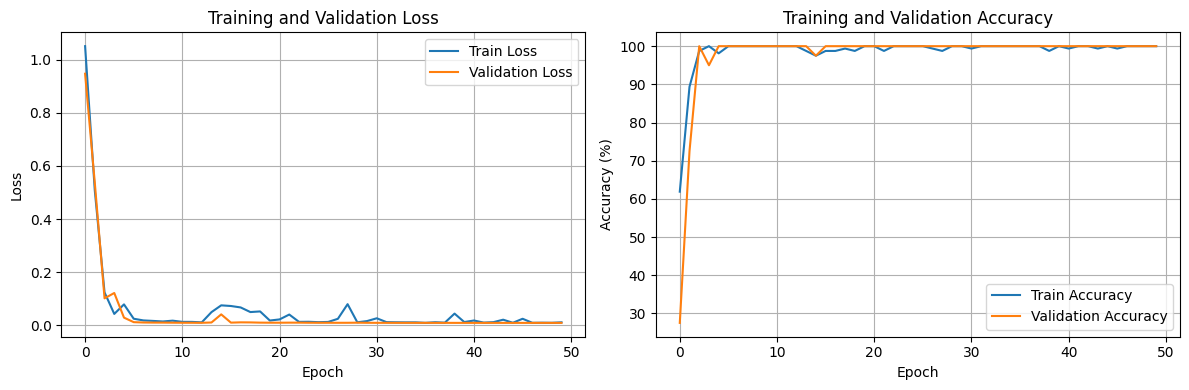

Training completed!
Best model saved as 'best_drone_classifier.pth'

TO USE WITH REAL DRONE AUDIO DATA:
1. Organize your WAV files like this:
   drone_data/
   ├── quadcopter/
   │   ├── recording1.wav
   │   ├── recording2.wav
   │   └── ...
   ├── hexacopter/
   │   ├── recording1.wav
   │   └── ...
   └── ...

2. Load your data:
   wav_files, labels = load_drone_data('path/to/drone_data')
   train_files, val_files, train_labels, val_labels = train_test_split(...)

3. Create datasets:
   train_dataset = RealDroneDataset(train_files, train_labels)
   val_dataset = RealDroneDataset(val_files, val_labels)

4. Train as usual!


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio
import torchaudio.transforms as T
import numpy as np
import os
import librosa
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List
import warnings
warnings.filterwarnings('ignore')

class SyntheticDroneDataset(Dataset):
    """Synthetic drone audio dataset for demonstration"""

    def __init__(self, num_samples_per_class: int, drone_types: List[str],
                 sr: int = 16000, duration: float = 3.0, seed: int = 42):
        self.sr = sr
        self.duration = duration
        self.max_length = int(sr * duration)
        self.seed = seed

        # Create labels
        self.labels = []
        for drone_type in drone_types:
            self.labels.extend([drone_type] * num_samples_per_class)

        # Initialize label encoder
        self.label_encoder = LabelEncoder()
        self.encoded_labels = self.label_encoder.fit_transform(self.labels)

    def __len__(self):
        return len(self.labels)

    def _generate_drone_audio(self, drone_type: str, sample_idx: int) -> torch.Tensor:
        """Generate realistic synthetic drone audio"""
        # Set seed for reproducibility
        np.random.seed(self.seed + sample_idx)

        t = np.linspace(0, self.duration, self.max_length)
        signal = np.zeros_like(t)

        # Different drone signatures
        if drone_type == 'quadcopter':
            # 4 rotors, fundamental around 75Hz
            base_freq = 75 + np.random.normal(0, 8)
            signal += 0.6 * np.sin(2 * np.pi * base_freq * t)
            signal += 0.4 * np.sin(2 * np.pi * base_freq * 2 * t)
            signal += 0.2 * np.sin(2 * np.pi * base_freq * 3 * t)

        elif drone_type == 'hexacopter':
            # 6 rotors, different harmonic content
            base_freq = 65 + np.random.normal(0, 6)
            signal += 0.5 * np.sin(2 * np.pi * base_freq * t)
            signal += 0.35 * np.sin(2 * np.pi * base_freq * 1.5 * t)
            signal += 0.25 * np.sin(2 * np.pi * base_freq * 2.5 * t)
            signal += 0.15 * np.sin(2 * np.pi * base_freq * 4 * t)

        elif drone_type == 'octocopter':
            # 8 rotors, complex harmonics
            base_freq = 55 + np.random.normal(0, 10)
            signal += 0.4 * np.sin(2 * np.pi * base_freq * t)
            signal += 0.3 * np.sin(2 * np.pi * base_freq * 1.3 * t)
            signal += 0.25 * np.sin(2 * np.pi * base_freq * 2.1 * t)
            signal += 0.2 * np.sin(2 * np.pi * base_freq * 3.7 * t)
            signal += 0.15 * np.sin(2 * np.pi * base_freq * 5.2 * t)

        elif drone_type == 'racing_drone':
            # High performance, higher frequency
            base_freq = 120 + np.random.normal(0, 15)
            signal += 0.7 * np.sin(2 * np.pi * base_freq * t)
            signal += 0.5 * np.sin(2 * np.pi * base_freq * 1.8 * t)
            signal += 0.3 * np.sin(2 * np.pi * base_freq * 2.7 * t)
            # Add high-frequency content
            signal += 0.2 * np.random.normal(0, 0.15, len(t))

        # Add realistic variations
        # RPM modulation (throttle changes)
        modulation = 1 + 0.15 * np.sin(2 * np.pi * 1.5 * t + np.random.uniform(0, 2*np.pi))
        signal *= modulation

        # Add background noise
        signal += 0.05 * np.random.normal(0, 1, len(t))

        # Add some wind/environmental effects
        wind_freq = 0.5 + np.random.uniform(-0.2, 0.2)
        signal += 0.03 * np.sin(2 * np.pi * wind_freq * t)

        # Normalize to prevent clipping
        if np.max(np.abs(signal)) > 0:
            signal = signal / np.max(np.abs(signal)) * 0.8

        return torch.tensor(signal, dtype=torch.float32)

    def __getitem__(self, idx):
        drone_type = self.labels[idx]
        waveform = self._generate_drone_audio(drone_type, idx)
        label = torch.tensor(self.encoded_labels[idx], dtype=torch.long)

        return waveform, label

class RealDroneDataset(Dataset):
    """Dataset for real drone audio files"""

    def __init__(self, wav_files: List[str], labels: List[str], sr: int = 16000, duration: float = 3.0):
        self.wav_files = wav_files
        self.labels = labels
        self.sr = sr
        self.duration = duration
        self.max_length = int(sr * duration)

        # Initialize label encoder
        self.label_encoder = LabelEncoder()
        self.encoded_labels = self.label_encoder.fit_transform(labels)

    def __len__(self):
        return len(self.wav_files)

    def __getitem__(self, idx):
        # Load audio file
        waveform, sample_rate = torchaudio.load(self.wav_files[idx])

        # Resample if necessary
        if sample_rate != self.sr:
            resampler = T.Resample(sample_rate, self.sr)
            waveform = resampler(waveform)

        # Convert to mono
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        # Pad or truncate to fixed length
        if waveform.shape[1] > self.max_length:
            waveform = waveform[:, :self.max_length]
        else:
            pad_length = self.max_length - waveform.shape[1]
            waveform = F.pad(waveform, (0, pad_length))

        waveform = waveform.squeeze(0)
        label = torch.tensor(self.encoded_labels[idx], dtype=torch.long)

        return waveform, label

class MFCCFeatureExtractor(nn.Module):
    """MFCC feature extraction module"""

    def __init__(self, sr: int = 16000, n_mfcc: int = 13, n_mels: int = 128):
        super().__init__()
        self.sr = sr
        self.n_mfcc = n_mfcc

        # MFCC transform
        self.mfcc_transform = T.MFCC(
            sample_rate=sr,
            n_mfcc=n_mfcc,
            melkwargs={
                'n_fft': 2048,
                'n_mels': n_mels,
                'hop_length': 512,
                'f_min': 0.0,
                'f_max': sr // 2,
                'power': 2.0,
                'normalized': True
            }
        )

        # Learnable projection
        self.projection = nn.Sequential(
            nn.Conv1d(n_mfcc, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(64)
        )

    def forward(self, x):
        # Extract MFCC features
        mfcc = self.mfcc_transform(x)  # (batch, n_mfcc, time)

        # Apply learned projection
        features = self.projection(mfcc)  # (batch, 128, 64)

        # Global average pooling
        return torch.mean(features, dim=2)  # (batch, 128)

class STFTCNNExtractor(nn.Module):
    """CNN-based feature extraction from STFT spectrograms"""

    def __init__(self, sr: int = 16000):
        super().__init__()
        self.sr = sr

        # STFT transform
        self.stft_transform = T.Spectrogram(
            n_fft=2048,
            hop_length=512,
            power=2.0,
            normalized=True
        )

        # CNN layers
        self.cnn = nn.Sequential(
            # First conv block
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Second conv block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Third conv block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Fourth conv block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4))
        )

        # Final projection
        self.projection = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256)
        )

    def forward(self, x):
        # Compute STFT
        stft = self.stft_transform(x)  # (batch, freq, time)
        stft = stft.unsqueeze(1)  # Add channel dimension (batch, 1, freq, time)

        # Apply CNN
        features = self.cnn(stft)  # (batch, 256, 4, 4)
        features = features.view(features.size(0), -1)  # Flatten

        # Project to final embedding
        return self.projection(features)  # (batch, 256)

class RNNFeatureExtractor(nn.Module):
    """RNN-based temporal feature extraction"""

    def __init__(self, input_size: int = 128, hidden_size: int = 128, num_layers: int = 2):
        super().__init__()

        # Mel spectrogram for RNN input
        self.mel_transform = T.MelSpectrogram(
            sample_rate=16000,
            n_fft=2048,
            hop_length=512,
            n_mels=input_size,
            normalized=True
        )

        # Bidirectional LSTM
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=0.3
        )

        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )

        # Output projection
        self.projection = nn.Linear(hidden_size * 2, 192)

    def forward(self, x):
        # Extract mel spectrogram
        mel = self.mel_transform(x)  # (batch, n_mels, time)
        mel = mel.transpose(1, 2)  # (batch, time, n_mels)

        # Apply LSTM
        lstm_out, _ = self.lstm(mel)  # (batch, time, hidden_size * 2)

        # Apply attention
        attention_weights = F.softmax(self.attention(lstm_out), dim=1)  # (batch, time, 1)
        attended = torch.sum(lstm_out * attention_weights, dim=1)  # (batch, hidden_size * 2)

        # Project to final embedding
        return self.projection(attended)  # (batch, 192)

class AudioAutoencoder(nn.Module):
    """Autoencoder for learning compressed audio representations"""

    def __init__(self, input_size: int = 48000, embedding_dim: int = 160):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 2048),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, embedding_dim)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(2048, input_size)
        )

    def forward(self, x):
        embedding = self.encoder(x)
        reconstruction = self.decoder(embedding)
        return embedding, reconstruction

class DroneClassifier(nn.Module):
    """End-to-end drone classification model"""

    def __init__(self, num_classes: int, sr: int = 16000, audio_length: int = 48000):
        super().__init__()

        # Feature extractors
        self.mfcc_extractor = MFCCFeatureExtractor(sr=sr)
        self.stft_cnn_extractor = STFTCNNExtractor(sr=sr)
        self.rnn_extractor = RNNFeatureExtractor()
        self.autoencoder = AudioAutoencoder(input_size=audio_length)

        # Feature fusion
        total_features = 128 + 256 + 192 + 160  # MFCC + STFT-CNN + RNN + Autoencoder

        self.fusion_layer = nn.Sequential(
            nn.Linear(total_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # Extract features from different modules
        mfcc_features = self.mfcc_extractor(x)
        stft_features = self.stft_cnn_extractor(x)
        rnn_features = self.rnn_extractor(x)
        ae_features, reconstruction = self.autoencoder(x)

        # Concatenate all features
        combined_features = torch.cat([
            mfcc_features,
            stft_features,
            rnn_features,
            ae_features
        ], dim=1)

        # Fusion and classification
        fused_features = self.fusion_layer(combined_features)
        logits = self.classifier(fused_features)

        return logits, reconstruction

class DroneClassificationTrainer:
    """Training and evaluation pipeline"""

    def __init__(self, model: nn.Module, device: torch.device):
        self.model = model.to(device)
        self.device = device
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def train_epoch(self, train_loader: DataLoader, optimizer: torch.optim.Optimizer,
                   criterion: nn.Module, autoencoder_weight: float = 0.1):
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0

        for batch_idx, (data, targets) in enumerate(train_loader):
            data, targets = data.to(self.device), targets.to(self.device)

            optimizer.zero_grad()

            # Forward pass
            logits, reconstruction = self.model(data)

            # Classification loss
            classification_loss = criterion(logits, targets)

            # Autoencoder reconstruction loss
            reconstruction_loss = F.mse_loss(reconstruction, data)

            # Combined loss
            loss = classification_loss + autoencoder_weight * reconstruction_loss

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = logits.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        avg_loss = total_loss / len(train_loader)
        accuracy = 100. * correct / total

        return avg_loss, accuracy

    def evaluate(self, val_loader: DataLoader, criterion: nn.Module,
                autoencoder_weight: float = 0.1):
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(self.device), targets.to(self.device)

                logits, reconstruction = self.model(data)

                classification_loss = criterion(logits, targets)
                reconstruction_loss = F.mse_loss(reconstruction, data)
                loss = classification_loss + autoencoder_weight * reconstruction_loss

                total_loss += loss.item()
                _, predicted = logits.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        avg_loss = total_loss / len(val_loader)
        accuracy = 100. * correct / total

        return avg_loss, accuracy

    def train(self, train_loader: DataLoader, val_loader: DataLoader,
              epochs: int = 50, lr: float = 0.001, autoencoder_weight: float = 0.1):

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(self.model.parameters(), lr=lr, weight_decay=0.01)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

        best_val_acc = 0

        for epoch in range(epochs):
            # Train
            train_loss, train_acc = self.train_epoch(
                train_loader, optimizer, criterion, autoencoder_weight
            )

            # Validate
            val_loss, val_acc = self.evaluate(val_loader, criterion, autoencoder_weight)

            # Update learning rate
            scheduler.step()

            # Store metrics
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_accuracies.append(train_acc)
            self.val_accuracies.append(val_acc)

            # Save best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(self.model.state_dict(), 'best_drone_classifier.pth')

            # Print progress
            if (epoch + 1) % 5 == 0:
                print(f'Epoch [{epoch+1}/{epochs}]')
                print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
                print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
                print(f'LR: {scheduler.get_last_lr()[0]:.6f}')
                print('-' * 50)

    def plot_training_history(self):
        """Plot training curves"""
        fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 4))

        # Loss curves
        ax1.plot(self.train_losses, label='Train Loss')
        ax1.plot(self.val_losses, label='Validation Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)

        # Accuracy curves
        ax2.plot(self.train_accuracies, label='Train Accuracy')
        ax2.plot(self.val_accuracies, label='Validation Accuracy')
        ax2.set_title('Training and Validation Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.show()

def load_drone_data(data_dir: str) -> Tuple[List[str], List[str]]:
    """
    Load drone audio data from directory structure:
    data_dir/
    ├── drone_type_1/
    │   ├── audio1.wav
    │   ├── audio2.wav
    │   └── ...
    ├── drone_type_2/
    │   ├── audio1.wav
    │   └── ...
    """
    wav_files = []
    labels = []

    for drone_type in os.listdir(data_dir):
        drone_dir = os.path.join(data_dir, drone_type)
        if os.path.isdir(drone_dir):
            for audio_file in os.listdir(drone_dir):
                if audio_file.endswith('.wav'):
                    wav_files.append(os.path.join(drone_dir, audio_file))
                    labels.append(drone_type)

    return wav_files, labels

# Main training function with synthetic data
def main():
    # Configuration
    SAMPLE_RATE = 16000
    AUDIO_DURATION = 3.0  # seconds
    BATCH_SIZE = 16
    EPOCHS = 50
    LEARNING_RATE = 0.001

    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    # Create synthetic dataset
    drone_types = ['quadcopter', 'hexacopter', 'octocopter', 'racing_drone']
    print("Creating synthetic drone audio dataset...")

    # Create datasets
    train_dataset = SyntheticDroneDataset(
        num_samples_per_class=40,  # 40 samples per class for training
        drone_types=drone_types,
        sr=SAMPLE_RATE,
        duration=AUDIO_DURATION,
        seed=42
    )

    val_dataset = SyntheticDroneDataset(
        num_samples_per_class=10,  # 10 samples per class for validation
        drone_types=drone_types,
        sr=SAMPLE_RATE,
        duration=AUDIO_DURATION,
        seed=123  # Different seed for validation data
    )

    print(f'Training samples: {len(train_dataset)}')
    print(f'Validation samples: {len(val_dataset)}')
    print(f'Classes: {train_dataset.label_encoder.classes_}')

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    # Create model
    num_classes = len(drone_types)
    model = DroneClassifier(
        num_classes=num_classes,
        sr=SAMPLE_RATE,
        audio_length=int(SAMPLE_RATE * AUDIO_DURATION)
    )

    print(f'Model parameters: {sum(p.numel() for p in model.parameters()):,}')

    # Create trainer and train
    trainer = DroneClassificationTrainer(model, device)

    print("Starting training...")
    trainer.train(
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=EPOCHS,
        lr=LEARNING_RATE,
        autoencoder_weight=0.1
    )

    # Plot results
    trainer.plot_training_history()

    print("Training completed!")
    print("Best model saved as 'best_drone_classifier.pth'")

    # Show how to use with real data
    print("\n" + "="*60)
    print("TO USE WITH REAL DRONE AUDIO DATA:")
    print("="*60)
    print("1. Organize your WAV files like this:")
    print("   drone_data/")
    print("   ├── quadcopter/")
    print("   │   ├── recording1.wav")
    print("   │   ├── recording2.wav")
    print("   │   └── ...")
    print("   ├── hexacopter/")
    print("   │   ├── recording1.wav")
    print("   │   └── ...")
    print("   └── ...")
    print()
    print("2. Load your data:")
    print("   wav_files, labels = load_drone_data('path/to/drone_data')")
    print("   train_files, val_files, train_labels, val_labels = train_test_split(...)")
    print()
    print("3. Create datasets:")
    print("   train_dataset = RealDroneDataset(train_files, train_labels)")
    print("   val_dataset = RealDroneDataset(val_files, val_labels)")
    print()
    print("4. Train as usual!")

if __name__ == "__main__":
    main()

### FLOPS Calculations

In [ ]:
!pip install ptflops


In [ ]:
from ptflops import get_model_complexity_info

# Create model
SAMPLE_RATE = 16000
AUDIO_DURATION = 3.0
num_classes = 4
audio_length = int(SAMPLE_RATE * AUDIO_DURATION)

model = DroneClassifier(num_classes=num_classes, sr=SAMPLE_RATE, audio_length=audio_length)

# Since your model expects [batch, audio_length],
# wrap into [batch, 1, audio_length] for FLOPs tool
with torch.cuda.device(0):  # if CUDA available
    macs, params = get_model_complexity_info(
        model,
        (audio_length,),    # input size WITHOUT batch
        as_strings=True,
        print_per_layer_stat=True,
        verbose=True
    )

print(f"FLOPs: {macs}")
print(f"Params: {params}")


DroneClassifier(
  206.0 M, 100.000% Params, 1.62 GMac, 97.809% MACs, 
  (mfcc_extractor): MFCCFeatureExtractor(
    27.65 k, 0.013% Params, 2.63 MMac, 0.158% MACs, 
    (mfcc_transform): MFCC(
      0, 0.000% Params, 0.0 Mac, 0.000% MACs, 
      (amplitude_to_DB): AmplitudeToDB(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
      (MelSpectrogram): MelSpectrogram(
        0, 0.000% Params, 0.0 Mac, 0.000% MACs, 
        (spectrogram): Spectrogram(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
        (mel_scale): MelScale(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
      )
    )
    (projection): Sequential(
      27.65 k, 0.013% Params, 2.63 MMac, 0.158% MACs, 
      (0): Conv1d(2.56 k, 0.001% Params, 240.64 KMac, 0.015% MACs, 13, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(128, 0.000% Params, 12.03 KMac, 0.001% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(0, 0.000% Params, 6.02 KMac, 0.000% MACs, )
      (3): Conv1d(24.7 k,

### 25 epochs with Confu. Matrix

Using device: cuda
Model parameters: 206,000,933
Epoch [5/25]
Train Loss: 0.0299, Train Acc: 99.38%
Val Loss: 0.0120, Val Acc: 100.00%
LR: 0.000905
--------------------------------------------------
Epoch [10/25]
Train Loss: 0.0114, Train Acc: 100.00%
Val Loss: 0.0091, Val Acc: 100.00%
LR: 0.000655
--------------------------------------------------
Epoch [15/25]
Train Loss: 0.0099, Train Acc: 100.00%
Val Loss: 0.0084, Val Acc: 100.00%
LR: 0.000345
--------------------------------------------------
Epoch [20/25]
Train Loss: 0.0181, Train Acc: 100.00%
Val Loss: 0.0082, Val Acc: 100.00%
LR: 0.000095
--------------------------------------------------
Epoch [25/25]
Train Loss: 0.0105, Train Acc: 100.00%
Val Loss: 0.0081, Val Acc: 100.00%
LR: 0.000000
--------------------------------------------------


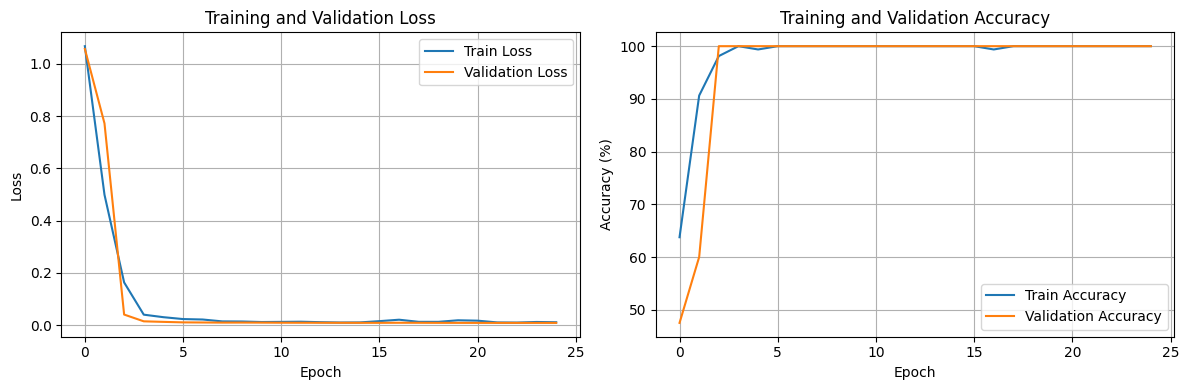

In [ ]:
def main():
    # Configuration
    SAMPLE_RATE = 16000
    AUDIO_DURATION = 3.0  # seconds
    BATCH_SIZE = 16
    EPOCHS = 25
    LEARNING_RATE = 0.001

    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    # Create synthetic dataset
    drone_types = ['quadcopter', 'hexacopter', 'octocopter', 'racing_drone']

    train_dataset = SyntheticDroneDataset(
        num_samples_per_class=40,
        drone_types=drone_types,
        sr=SAMPLE_RATE,
        duration=AUDIO_DURATION,
        seed=42
    )

    val_dataset = SyntheticDroneDataset(
        num_samples_per_class=10,
        drone_types=drone_types,
        sr=SAMPLE_RATE,
        duration=AUDIO_DURATION,
        seed=123
    )

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    # Create model
    num_classes = len(drone_types)
    model = DroneClassifier(
        num_classes=num_classes,
        sr=SAMPLE_RATE,
        audio_length=int(SAMPLE_RATE * AUDIO_DURATION)
    )

    print(f'Model parameters: {sum(p.numel() for p in model.parameters()):,}')

    # Create trainer and train
    trainer = DroneClassificationTrainer(model, device)
    trainer.train(
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=EPOCHS,
        lr=LEARNING_RATE,
        autoencoder_weight=0.1
    )

    trainer.plot_training_history()

    # Return objects for further evaluation
    return trainer, val_loader, drone_types, device

# Run main and get objects
trainer, val_loader, class_names, device = main()


Confusion Matrix:
[[10  0  0  0]
 [ 0 10  0  0]
 [ 0  0 10  0]
 [ 0  0  0 10]]


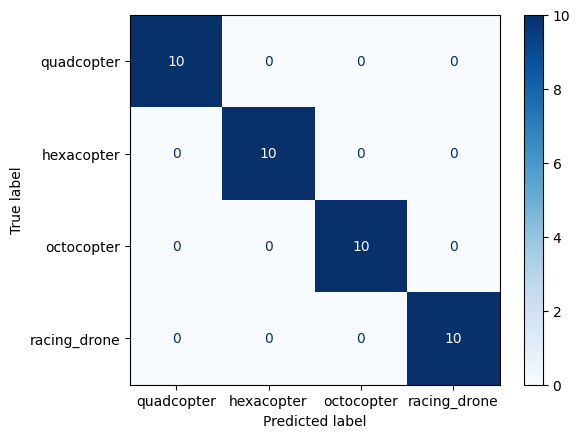

Classification Report:
              precision    recall  f1-score   support

  quadcopter       1.00      1.00      1.00        10
  hexacopter       1.00      1.00      1.00        10
  octocopter       1.00      1.00      1.00        10
racing_drone       1.00      1.00      1.00        10

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Overall Accuracy: 100.00%


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import torch
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(trainer, val_loader, device, class_names):
    trainer.model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, targets in val_loader:
            data, targets = data.to(device), targets.to(device)
            logits, _ = trainer.model(data)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    # Classification report
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print("Classification Report:")
    print(report)

    # Overall accuracy
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels)) * 100
    print(f"Overall Accuracy: {accuracy:.2f}%")

# Usage
evaluate_model(trainer, val_loader, device, class_names)


# Real World Data

In [ ]:
# Load real data
wav_files, labels = load_drone_data('drone_data')
train_files, val_files, train_labels, val_labels = train_test_split(...)

# Use RealDroneDataset instead
train_dataset = RealDroneDataset(train_files, train_labels, sr=SAMPLE_RATE, duration=AUDIO_DURATION)
val_dataset = RealDroneDataset(val_files, val_labels, sr=SAMPLE_RATE, duration=AUDIO_DURATION)

In [ ]:
!wget --header="User-Agent: Mozilla/5.0" \
"https://salford.figshare.com/ndownloader/articles/22133411/versions/3" -O dataset.zip

--2025-08-24 13:05:03--  https://salford.figshare.com/ndownloader/articles/22133411/versions/3
Resolving salford.figshare.com (salford.figshare.com)... 54.229.40.185, 52.208.255.91, 52.49.118.142, ...
Connecting to salford.figshare.com (salford.figshare.com)|54.229.40.185|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 742153893 (708M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>] 707.77M  13.4MB/s    in 49s     

2025-08-24 13:05:53 (14.3 MB/s) - ‘dataset.zip’ saved [742153893/742153893]



In [ ]:
!unzip -q dataset.zip -d ./drone_data

In [ ]:
!git clone https://github.com/saraalemadi/DroneAudioDataset.git

Cloning into 'DroneAudioDataset'...
remote: Enumerating objects: 10649, done.
remote: Counting objects: 100% (6/6), done.
remote: Total 10649 (delta 5), reused 5 (delta 5), pack-reused 10643 (from 1)
Receiving objects: 100% (10649/10649), 274.31 MiB | 11.72 MiB/s, done.
Resolving deltas: 100% (181/181), done.
Updating files: 100% (23409/23409), done.


In [ ]:
!mv /content/DroneAudioDataset/Binary_Drone_Audio/* .

### Binary_Drone_data CLassification _NO augmentation

Using device: cuda
DATASET ANALYSIS
📁 unknown: 10372 WAV files
📁 yes_drone: 1332 WAV files

Total WAV files found: 11704
Folders with audio: 2

Loading real drone audio dataset...
Scanning folder: unknown
  Found 10372 WAV files
Scanning folder: yes_drone
  Found 1332 WAV files
Found 11704 audio files
Unique labels: {'unknown', 'drone'}
Dataset split - Training: 9363 samples
Label distribution: {np.str_('drone'): np.int64(1066), np.str_('unknown'): np.int64(8297)}
Scanning folder: unknown
  Found 10372 WAV files
Scanning folder: yes_drone
  Found 1332 WAV files
Found 11704 audio files
Unique labels: {'unknown', 'drone'}
Dataset split - Validation: 2341 samples
Label distribution: {np.str_('drone'): np.int64(266), np.str_('unknown'): np.int64(2075)}
Training samples: 9363
Validation samples: 2341
Classes: ['drone' 'unknown']
Model parameters: 206,000,675
Starting training...
Epoch [5/30]
Train Loss: 0.1063, Train Acc: 97.05%
Val Loss: 0.0663, Val Acc: 97.52%
Best Val Acc: 97.52%
LR: 0.0

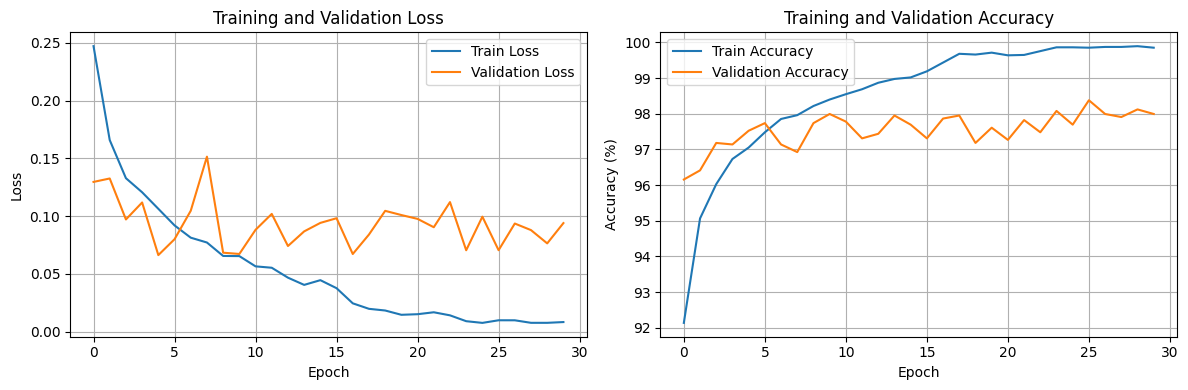

Training completed!
Best model saved as 'best_drone_classifier.pth'

Sample prediction:
Actual: unknown
Predicted: unknown
Confidence: 1.000


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio
import torchaudio.transforms as T
import numpy as np
import os
import librosa
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List
import warnings
warnings.filterwarnings('ignore')

class NoiseBasedDroneDataset(Dataset):
    """Dataset for drone audio files stored in noise/binary_folders structure"""

    def __init__(self, noise_folder_path: str, sr: int = 16000, duration: float = 3.0,
                 train_split: bool = True, test_size: float = 0.2, random_state: int = 42):
        self.sr = sr
        self.duration = duration
        self.max_length = int(sr * duration)

        # Load all WAV files from binary folders
        self.wav_files, self.labels = self._load_drone_files(noise_folder_path)

        print(f"Found {len(self.wav_files)} audio files")
        print(f"Unique labels: {set(self.labels)}")

        # Split into train/validation
        if len(set(self.labels)) > 1:  # Only split if we have multiple classes
            train_files, val_files, train_labels, val_labels = train_test_split(
                self.wav_files, self.labels, test_size=test_size,
                random_state=random_state, stratify=self.labels
            )

            if train_split:
                self.wav_files = train_files
                self.labels = train_labels
            else:
                self.wav_files = val_files
                self.labels = val_labels

        # Initialize label encoder
        self.label_encoder = LabelEncoder()
        self.encoded_labels = self.label_encoder.fit_transform(self.labels)

        print(f"Dataset split - {'Training' if train_split else 'Validation'}: {len(self.wav_files)} samples")
        print(f"Label distribution: {dict(zip(*np.unique(self.labels, return_counts=True)))}")

    def _load_drone_files(self, noise_folder_path: str) -> Tuple[List[str], List[str]]:
        """Load WAV files from noise folder with binary subfolders"""
        wav_files = []
        labels = []

        if not os.path.exists(noise_folder_path):
            raise FileNotFoundError(f"Noise folder not found: {noise_folder_path}")

        # Iterate through all subdirectories in noise folder
        for folder_name in os.listdir(noise_folder_path):
            folder_path = os.path.join(noise_folder_path, folder_name)

            if os.path.isdir(folder_path):
                print(f"Scanning folder: {folder_name}")

                # Look for WAV files in this folder
                wav_count = 0
                for file_name in os.listdir(folder_path):
                    if file_name.lower().endswith('.wav'):
                        file_path = os.path.join(folder_path, file_name)
                        wav_files.append(file_path)

                        # Use folder name as label (you can modify this logic)
                        # For binary classification, you might want to map folder names to drone/no-drone
                        labels.append(self._map_folder_to_label(folder_name))
                        wav_count += 1

                print(f"  Found {wav_count} WAV files")

        if len(wav_files) == 0:
            raise ValueError(f"No WAV files found in {noise_folder_path}")

        return wav_files, labels

    def _map_folder_to_label(self, folder_name: str) -> str:
        """Map folder names to meaningful labels"""
        folder_lower = folder_name.lower()

        # You can customize this mapping based on your folder structure
        # Example mappings:
        if 'drone' in folder_lower or 'quad' in folder_lower or 'hex' in folder_lower or 'oct' in folder_lower:
            return 'drone'
        elif 'background' in folder_lower or 'ambient' in folder_lower or 'noise' in folder_lower:
            return 'background'
        elif 'wind' in folder_lower:
            return 'wind'
        elif 'traffic' in folder_lower or 'car' in folder_lower:
            return 'traffic'
        elif 'bird' in folder_lower or 'animal' in folder_lower:
            return 'animal'
        else:
            # If no specific mapping, use folder name as-is
            return folder_name

    def __len__(self):
        return len(self.wav_files)

    def __getitem__(self, idx):
        try:
            # Load audio file
            waveform, sample_rate = torchaudio.load(self.wav_files[idx])

            # Resample if necessary
            if sample_rate != self.sr:
                resampler = T.Resample(sample_rate, self.sr)
                waveform = resampler(waveform)

            # Convert to mono if stereo
            if waveform.shape[0] > 1:
                waveform = torch.mean(waveform, dim=0, keepdim=True)

            # Pad or truncate to fixed length
            if waveform.shape[1] > self.max_length:
                # Random crop for training data augmentation
                start_idx = torch.randint(0, waveform.shape[1] - self.max_length + 1, (1,)).item()
                waveform = waveform[:, start_idx:start_idx + self.max_length]
            else:
                # Pad with zeros
                pad_length = self.max_length - waveform.shape[1]
                waveform = F.pad(waveform, (0, pad_length))

            waveform = waveform.squeeze(0)

            # Add small amount of noise for robustness (data augmentation)
            if torch.rand(1).item() < 0.3:  # 30% chance
                noise = torch.randn_like(waveform) * 0.01
                waveform = waveform + noise

            label = torch.tensor(self.encoded_labels[idx], dtype=torch.long)

            return waveform, label

        except Exception as e:
            print(f"Error loading {self.wav_files[idx]}: {str(e)}")
            # Return a zero tensor and the first label as fallback
            waveform = torch.zeros(self.max_length)
            label = torch.tensor(0, dtype=torch.long)
            return waveform, label

class SyntheticDroneDataset(Dataset):
    """Synthetic drone audio dataset for demonstration and augmentation"""

    def __init__(self, num_samples_per_class: int, drone_types: List[str],
                 sr: int = 16000, duration: float = 3.0, seed: int = 42):
        self.sr = sr
        self.duration = duration
        self.max_length = int(sr * duration)
        self.seed = seed

        # Create labels
        self.labels = []
        for drone_type in drone_types:
            self.labels.extend([drone_type] * num_samples_per_class)

        # Initialize label encoder
        self.label_encoder = LabelEncoder()
        self.encoded_labels = self.label_encoder.fit_transform(self.labels)

    def __len__(self):
        return len(self.labels)

    def _generate_drone_audio(self, drone_type: str, sample_idx: int) -> torch.Tensor:
        """Generate realistic synthetic drone audio"""
        np.random.seed(self.seed + sample_idx)

        t = np.linspace(0, self.duration, self.max_length)
        signal = np.zeros_like(t)

        # Different drone signatures
        if drone_type == 'drone':
            # Generic drone signature
            base_freq = 70 + np.random.normal(0, 10)
            signal += 0.6 * np.sin(2 * np.pi * base_freq * t)
            signal += 0.4 * np.sin(2 * np.pi * base_freq * 2 * t)
            signal += 0.2 * np.sin(2 * np.pi * base_freq * 3 * t)

        elif drone_type == 'background':
            # Background noise
            signal += 0.1 * np.random.normal(0, 1, len(t))
            # Add some low-frequency rumble
            signal += 0.05 * np.sin(2 * np.pi * 2 * t + np.random.uniform(0, 2*np.pi))

        # Add realistic variations
        modulation = 1 + 0.1 * np.sin(2 * np.pi * 1.2 * t + np.random.uniform(0, 2*np.pi))
        signal *= modulation

        # Add background noise
        signal += 0.03 * np.random.normal(0, 1, len(t))

        # Normalize
        if np.max(np.abs(signal)) > 0:
            signal = signal / np.max(np.abs(signal)) * 0.8

        return torch.tensor(signal, dtype=torch.float32)

    def __getitem__(self, idx):
        drone_type = self.labels[idx]
        waveform = self._generate_drone_audio(drone_type, idx)
        label = torch.tensor(self.encoded_labels[idx], dtype=torch.long)

        return waveform, label

class MFCCFeatureExtractor(nn.Module):
    """MFCC feature extraction module"""

    def __init__(self, sr: int = 16000, n_mfcc: int = 13, n_mels: int = 128):
        super().__init__()
        self.sr = sr
        self.n_mfcc = n_mfcc

        self.mfcc_transform = T.MFCC(
            sample_rate=sr,
            n_mfcc=n_mfcc,
            melkwargs={
                'n_fft': 2048,
                'n_mels': n_mels,
                'hop_length': 512,
                'f_min': 0.0,
                'f_max': sr // 2,
                'power': 2.0,
                'normalized': True
            }
        )

        self.projection = nn.Sequential(
            nn.Conv1d(n_mfcc, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(64)
        )

    def forward(self, x):
        mfcc = self.mfcc_transform(x)
        features = self.projection(mfcc)
        return torch.mean(features, dim=2)

class STFTCNNExtractor(nn.Module):
    """CNN-based feature extraction from STFT spectrograms"""

    def __init__(self, sr: int = 16000):
        super().__init__()
        self.sr = sr

        self.stft_transform = T.Spectrogram(
            n_fft=2048,
            hop_length=512,
            power=2.0,
            normalized=True
        )

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4))
        )

        self.projection = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256)
        )

    def forward(self, x):
        stft = self.stft_transform(x)
        stft = stft.unsqueeze(1)
        features = self.cnn(stft)
        features = features.view(features.size(0), -1)
        return self.projection(features)

class RNNFeatureExtractor(nn.Module):
    """RNN-based temporal feature extraction"""

    def __init__(self, input_size: int = 128, hidden_size: int = 128, num_layers: int = 2):
        super().__init__()

        self.mel_transform = T.MelSpectrogram(
            sample_rate=16000,
            n_fft=2048,
            hop_length=512,
            n_mels=input_size,
            normalized=True
        )

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=0.3 if num_layers > 1 else 0
        )

        self.attention = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )

        self.projection = nn.Linear(hidden_size * 2, 192)

    def forward(self, x):
        mel = self.mel_transform(x)
        mel = mel.transpose(1, 2)

        lstm_out, _ = self.lstm(mel)
        attention_weights = F.softmax(self.attention(lstm_out), dim=1)
        attended = torch.sum(lstm_out * attention_weights, dim=1)

        return self.projection(attended)

class AudioAutoencoder(nn.Module):
    """Autoencoder for learning compressed audio representations"""

    def __init__(self, input_size: int = 48000, embedding_dim: int = 160):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_size, 2048),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, embedding_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(2048, input_size)
        )

    def forward(self, x):
        embedding = self.encoder(x)
        reconstruction = self.decoder(embedding)
        return embedding, reconstruction

class DroneClassifier(nn.Module):
    """End-to-end drone classification model"""

    def __init__(self, num_classes: int, sr: int = 16000, audio_length: int = 48000):
        super().__init__()

        self.mfcc_extractor = MFCCFeatureExtractor(sr=sr)
        self.stft_cnn_extractor = STFTCNNExtractor(sr=sr)
        self.rnn_extractor = RNNFeatureExtractor()
        self.autoencoder = AudioAutoencoder(input_size=audio_length)

        total_features = 128 + 256 + 192 + 160

        self.fusion_layer = nn.Sequential(
            nn.Linear(total_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        mfcc_features = self.mfcc_extractor(x)
        stft_features = self.stft_cnn_extractor(x)
        rnn_features = self.rnn_extractor(x)
        ae_features, reconstruction = self.autoencoder(x)

        combined_features = torch.cat([
            mfcc_features,
            stft_features,
            rnn_features,
            ae_features
        ], dim=1)

        fused_features = self.fusion_layer(combined_features)
        logits = self.classifier(fused_features)

        return logits, reconstruction

class DroneClassificationTrainer:
    """Training and evaluation pipeline"""

    def __init__(self, model: nn.Module, device: torch.device):
        self.model = model.to(device)
        self.device = device
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def train_epoch(self, train_loader: DataLoader, optimizer: torch.optim.Optimizer,
                   criterion: nn.Module, autoencoder_weight: float = 0.1):
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0

        for batch_idx, (data, targets) in enumerate(train_loader):
            data, targets = data.to(self.device), targets.to(self.device)

            optimizer.zero_grad()

            logits, reconstruction = self.model(data)

            classification_loss = criterion(logits, targets)
            reconstruction_loss = F.mse_loss(reconstruction, data)
            loss = classification_loss + autoencoder_weight * reconstruction_loss

            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item()
            _, predicted = logits.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        avg_loss = total_loss / len(train_loader)
        accuracy = 100. * correct / total

        return avg_loss, accuracy

    def evaluate(self, val_loader: DataLoader, criterion: nn.Module,
                autoencoder_weight: float = 0.1):
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(self.device), targets.to(self.device)

                logits, reconstruction = self.model(data)

                classification_loss = criterion(logits, targets)
                reconstruction_loss = F.mse_loss(reconstruction, data)
                loss = classification_loss + autoencoder_weight * reconstruction_loss

                total_loss += loss.item()
                _, predicted = logits.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        avg_loss = total_loss / len(val_loader)
        accuracy = 100. * correct / total

        return avg_loss, accuracy

    def train(self, train_loader: DataLoader, val_loader: DataLoader,
              epochs: int = 50, lr: float = 0.001, autoencoder_weight: float = 0.1):

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(self.model.parameters(), lr=lr, weight_decay=0.01)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5)

        best_val_acc = 0
        patience = 0
        max_patience = 15

        for epoch in range(epochs):
            train_loss, train_acc = self.train_epoch(
                train_loader, optimizer, criterion, autoencoder_weight
            )

            val_loss, val_acc = self.evaluate(val_loader, criterion, autoencoder_weight)

            scheduler.step(val_acc)

            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_accuracies.append(train_acc)
            self.val_accuracies.append(val_acc)

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(self.model.state_dict(), 'best_drone_classifier.pth')
                patience = 0
            else:
                patience += 1

            if (epoch + 1) % 5 == 0:
                print(f'Epoch [{epoch+1}/{epochs}]')
                print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
                print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
                print(f'Best Val Acc: {best_val_acc:.2f}%')
                print(f'LR: {optimizer.param_groups[0]["lr"]:.6f}')
                print('-' * 50)

            if patience >= max_patience:
                print(f'Early stopping at epoch {epoch+1}')
                break

    def plot_training_history(self):
        """Plot training curves"""
        fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 4))

        ax1.plot(self.train_losses, label='Train Loss')
        ax1.plot(self.val_losses, label='Validation Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)

        ax2.plot(self.train_accuracies, label='Train Accuracy')
        ax2.plot(self.val_accuracies, label='Validation Accuracy')
        ax2.set_title('Training and Validation Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.show()

def analyze_dataset(noise_folder_path: str):
    """Analyze the dataset structure and content"""
    print("="*60)
    print("DATASET ANALYSIS")
    print("="*60)

    if not os.path.exists(noise_folder_path):
        print(f"Error: Folder {noise_folder_path} does not exist!")
        return

    total_files = 0
    folder_stats = {}

    for folder_name in os.listdir(noise_folder_path):
        folder_path = os.path.join(noise_folder_path, folder_name)

        if os.path.isdir(folder_path):
            wav_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.wav')]
            wav_count = len(wav_files)
            folder_stats[folder_name] = wav_count
            total_files += wav_count

            print(f"📁 {folder_name}: {wav_count} WAV files")

            if wav_count > 0 and wav_count <= 3:  # Show sample files for small folders
                print(f"   Sample files: {', '.join(wav_files)}")

    print(f"\nTotal WAV files found: {total_files}")
    print(f"Folders with audio: {len([k for k, v in folder_stats.items() if v > 0])}")

    if total_files == 0:
        print("\n⚠️  WARNING: No WAV files found!")
        print("Please check your folder structure.")

# Main training function
def main():
    # Configuration
    NOISE_FOLDER_PATH = "/content/DroneAudioDataset/Binary_Drone_Audio"  # Update this path to your noise folder
    SAMPLE_RATE = 16000
    AUDIO_DURATION = 3.0
    BATCH_SIZE = 8  # Reduced batch size for stability
    EPOCHS = 30
    LEARNING_RATE = 0.001

    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    # Analyze dataset first
    analyze_dataset(NOISE_FOLDER_PATH)

    try:
        # Create datasets from real audio files
        print("\nLoading real drone audio dataset...")

        train_dataset = NoiseBasedDroneDataset(
            noise_folder_path=NOISE_FOLDER_PATH,
            sr=SAMPLE_RATE,
            duration=AUDIO_DURATION,
            train_split=True,
            test_size=0.2,
            random_state=42
        )

        val_dataset = NoiseBasedDroneDataset(
            noise_folder_path=NOISE_FOLDER_PATH,
            sr=SAMPLE_RATE,
            duration=AUDIO_DURATION,
            train_split=False,
            test_size=0.2,
            random_state=42
        )

        print(f'Training samples: {len(train_dataset)}')
        print(f'Validation samples: {len(val_dataset)}')
        print(f'Classes: {train_dataset.label_encoder.classes_}')

        # Check if we have enough data
        if len(train_dataset) < 10:
            print("\n⚠️  WARNING: Very few training samples. Consider:")
            print("1. Adding more audio files")
            print("2. Using data augmentation")
            print("3. Using synthetic data to supplement")

        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                                num_workers=0, drop_last=True)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=0, drop_last=False)

        # Create model
        num_classes = len(train_dataset.label_encoder.classes_)
        model = DroneClassifier(
            num_classes=num_classes,
            sr=SAMPLE_RATE,
            audio_length=int(SAMPLE_RATE * AUDIO_DURATION)
        )

        print(f'Model parameters: {sum(p.numel() for p in model.parameters()):,}')

        # Create trainer and train
        trainer = DroneClassificationTrainer(model, device)

        print("Starting training...")
        trainer.train(
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=EPOCHS,
            lr=LEARNING_RATE,
            autoencoder_weight=0.1
        )

        # Plot results
        trainer.plot_training_history()

        print("Training completed!")
        print("Best model saved as 'best_drone_classifier.pth'")

        # Test prediction on a sample
        model.eval()
        with torch.no_grad():
            sample_data, sample_label = val_dataset[0]
            sample_data = sample_data.unsqueeze(0).to(device)
            logits, _ = model(sample_data)
            predicted = torch.argmax(logits, dim=1)

            actual_label = train_dataset.label_encoder.inverse_transform([sample_label.item()])[0]
            predicted_label = train_dataset.label_encoder.inverse_transform([predicted.item()])[0]

            print(f"\nSample prediction:")
            print(f"Actual: {actual_label}")
            print(f"Predicted: {predicted_label}")
            print(f"Confidence: {torch.softmax(logits, dim=1).max().item():.3f}")

    except FileNotFoundError as e:
        print(f"\n❌ Error: {e}")
        print("\nPlease ensure your folder structure is like this:")
        print("noise/")
        print("├── folder1/")
        print("│   ├── audio1.wav")
        print("│   ├── audio2.wav")
        print("│   └── ...")
        print("├── folder2/")
        print("│   ├── audio1.wav")
        print("│   └── ...")
        print("└── ...")

    except Exception as e:
        print(f"\n❌ Unexpected error: {e}")
        print("Please check your data and try again.")

if __name__ == "__main__":
    main()